In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
import seaborn as sns
import pandas as pd
import spectral
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from tqdm.auto import tqdm
import concurrent.futures
import multiprocessing as mp
from lib_hyperspec import *
from run_task import *
import os

In [2]:
data_path = "/home/royabhinav/Desktop/CTIS/Data_Apr19/"

output_path = "/home/royabhinav/Desktop/CTIS/Output_Apr19/"

#get file names of all .tif files in the directory data_path

files = [f for f in os.listdir(data_path) if f.endswith('.tif')]

#remove the .tif extension from the file names
files = [f[:-4] for f in files]

print(files)

print(len(files))

calibration_file = "he7"

#run calibration tasks

known_peaks_He = np.array([447.1, 492.1, 501.5, 587.5, 667.8, 686.7, 706.5])

['BASALTP1', 'BASALTP3', 'HEM1', 'SPEC1', 'BASALTMP2', 'MAG2', 'SPEC3', 'BASALTM1', 'BASALTM2', 'BASALTMMP1', 'BASALT6', 'MAG1', 'BASALT5', 'SPEC5', 'HEM2', 'BASALTMMP2', 'BASALTMP3', 'BASALTP2', 'he7']
19


In [3]:
def load_cube(file):
    cube = np.load(output_path + file + '/'+file+'_cube.npy')
    wave = np.load(output_path + file + '/'+file+'_wavelengths.npy')

    return cube, wave

def plot_cube_slice_mean(cube, wave, wavelength):
    plt.figure(figsize=(10,10))
    #plot a slice of the cube at the wavelengths with difference less than 1 nm from the desired wavelength
    wave_index = np.where(np.abs(wave-wavelength)<1)[0]
    slice_of_cube = cube[:,:,wave_index]
    #taking mean over x and y
    slice_of_cube = np.mean(slice_of_cube, axis=2)
    plt.imshow(slice_of_cube, cmap='gray')
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Wavelength: ' + str(wavelength) + '$\pm$1 nm')
    plt.show()

def plot_cube_spectra(cube, wave, x, y):
    spectra_slice = cube[x, y, :]
    plt.figure(figsize=(16,9))
    plt.plot(wave, spectra_slice)
    plt.plot(wave, spectra_slice,'r.')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('Spectra at the pixel x=' + str(x) + ', y=' + str(y))
    plt.show()

def plot_cube_spectra_mean_3x3(cube, wave, x, y):
    spectra_slice0 = cube[x, y, :]
    spectra_slice = cube[x-1:x+2, y-1:y+2, :]
    spectra_slice = np.mean(spectra_slice, axis=(0,1))
    plt.figure(figsize=(16,9))
    plt.plot(wave, spectra_slice0,'-', label='Center pixel')
    plt.plot(wave, spectra_slice,'r.', label='Mean of 3x3 window')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('Mean spectra of a 3x3 pixel window centered at x=' + str(x) + ', y=' + str(y))
    plt.legend()
    plt.show()

def plot_cube_spectra_mean_11x11(cube, wave, x, y):
    spectra_slice0 = cube[x, y, :]
    spectra_slice = cube[x-5:x+6, y-5:y+6, :]
    spectra_slice = np.mean(spectra_slice, axis=(0,1))
    plt.figure(figsize=(16,9))
    plt.plot(wave, spectra_slice0,'-', label='Center pixel')
    plt.plot(wave, spectra_slice,'r.', label='Mean of 11x11 window')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('Mean spectra of a 11x11 pixel window centered at x=' + str(x) + ', y=' + str(y))
    plt.legend()
    plt.show()

In [4]:
# spec_cube1, wave1 = load_cube('SPEC1')

# print(spec_cube1.shape)
# print(min(wave1), max(wave1))

# plot_cube_slice_mean(spec_cube1, wave1, 500)

# plot_cube_spectra_mean_3x3(spec_cube1, wave1, 100, 100)

In [5]:
# spec_cube2, wave2 = load_cube('BASALT5')

# print(spec_cube2.shape)
# print(min(wave2), max(wave2))

# plot_cube_slice_mean(spec_cube2, wave2, 500)

# plot_cube_spectra_mean_3x3(spec_cube2, wave2, 100, 100)

In [6]:
def calibration_of_cube(file_sample, file_calibration, step=1):
	print('Loading Sample Cube')
	cube1 = np.load(output_path + file_sample + '/'+file_sample+'_cube.npy')
	wave1 = np.load(output_path + file_sample + '/'+file_sample+'_wavelengths.npy')

	print('Loading Calibration Cube')
	cube0 = np.load(output_path + file_calibration + '/'+file_calibration+'_cube.npy')
	wave0 = np.load(output_path + file_calibration + '/'+file_calibration+'_wavelengths.npy')

	print(cube1.shape, cube0.shape)
	print(min(wave1), max(wave1))
	print(min(wave0), max(wave0))

	print('Starting Calibration')
	min_w = np.ceil(np.max(max(min(wave1), min(wave0)))/step)*step
	max_w = np.floor(np.min(min(max(wave1), max(wave0)))/step)*step

	new_waves = np.arange(min_w, max_w+step, step)

	#print(min_w,max_w)

	#print(new_waves)

	new_cube = np.zeros((cube1.shape[0], cube1.shape[1], len(new_waves)))

	print('Calibrating')
	for i in tqdm(range(len(new_waves))):
		wave_index1 = np.where(np.abs(wave1-new_waves[i])<1)[0]
		wave_index0 = np.where(np.abs(wave0-new_waves[i])<1)[0]

		slice_of_cube1 = cube1[:,:,wave_index1]
		slice_of_cube0 = cube0[:,:,wave_index0]

		slice_of_cube1 = np.mean(slice_of_cube1, axis=2)
		slice_of_cube0 = np.mean(slice_of_cube0, axis=2)

		mean_of_cube0 = np.mean(slice_of_cube0)

		new_cube[:,:,i] = slice_of_cube1/mean_of_cube0

	#normalise the cube to have mean value 1
	#print(np.where(new_cube>1)[0])
	#print(np.max(new_cube),np.mean(new_cube),np.min(new_cube))
	new_cube = new_cube/np.mean(new_cube)
	#print(np.max(new_cube),np.mean(new_cube),np.min(new_cube))

	print('Done!')

	return new_cube, new_waves

Loading Sample Cube


Loading Calibration Cube
(314, 315, 1000) (332, 320, 1000)
449.6224883563609 860.6852638791856
394.7463248417953 864.7333784493208
Starting Calibration
Calibrating


  0%|          | 0/1644 [00:00<?, ?it/s]

Done!
(314, 315, 1644)
449.75 860.5


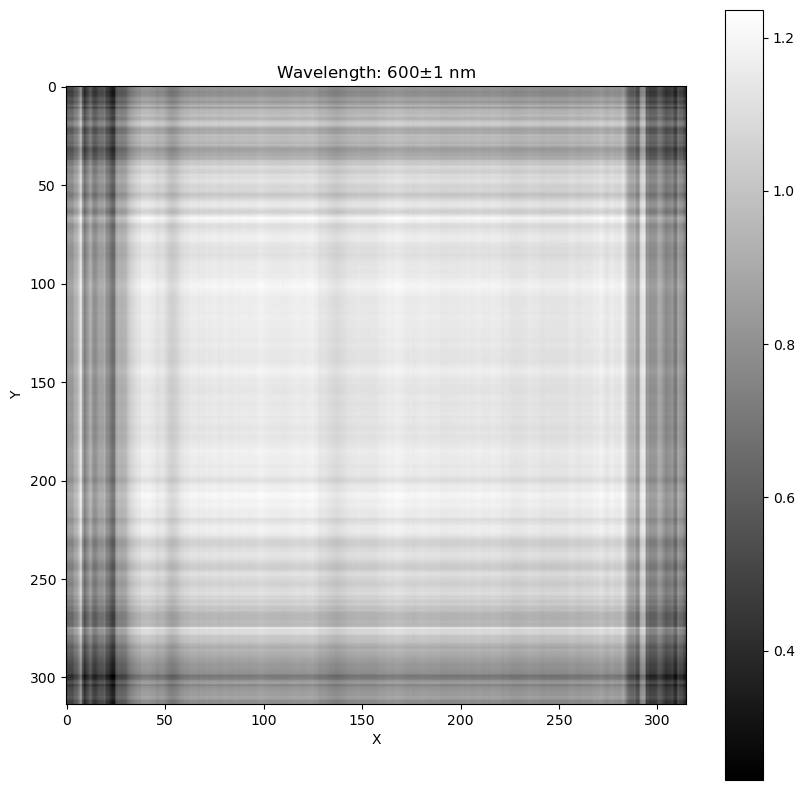

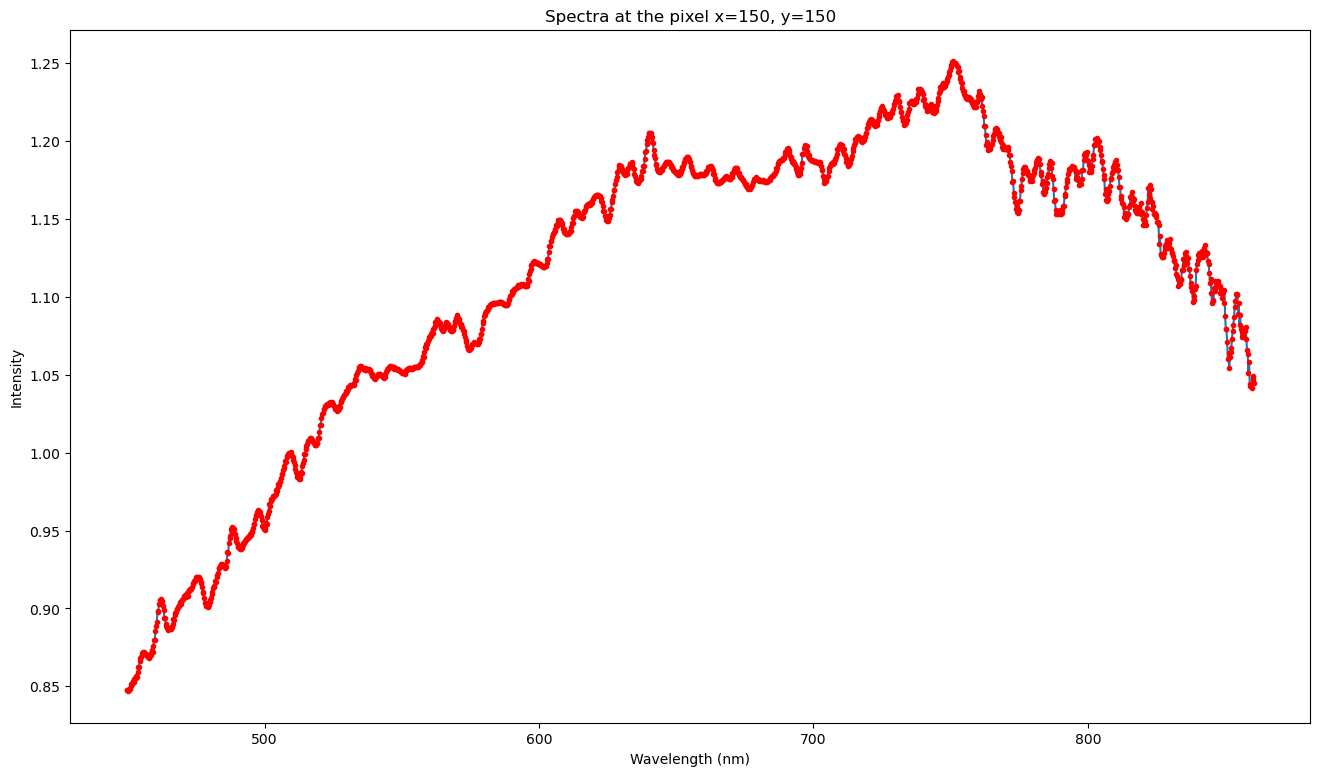

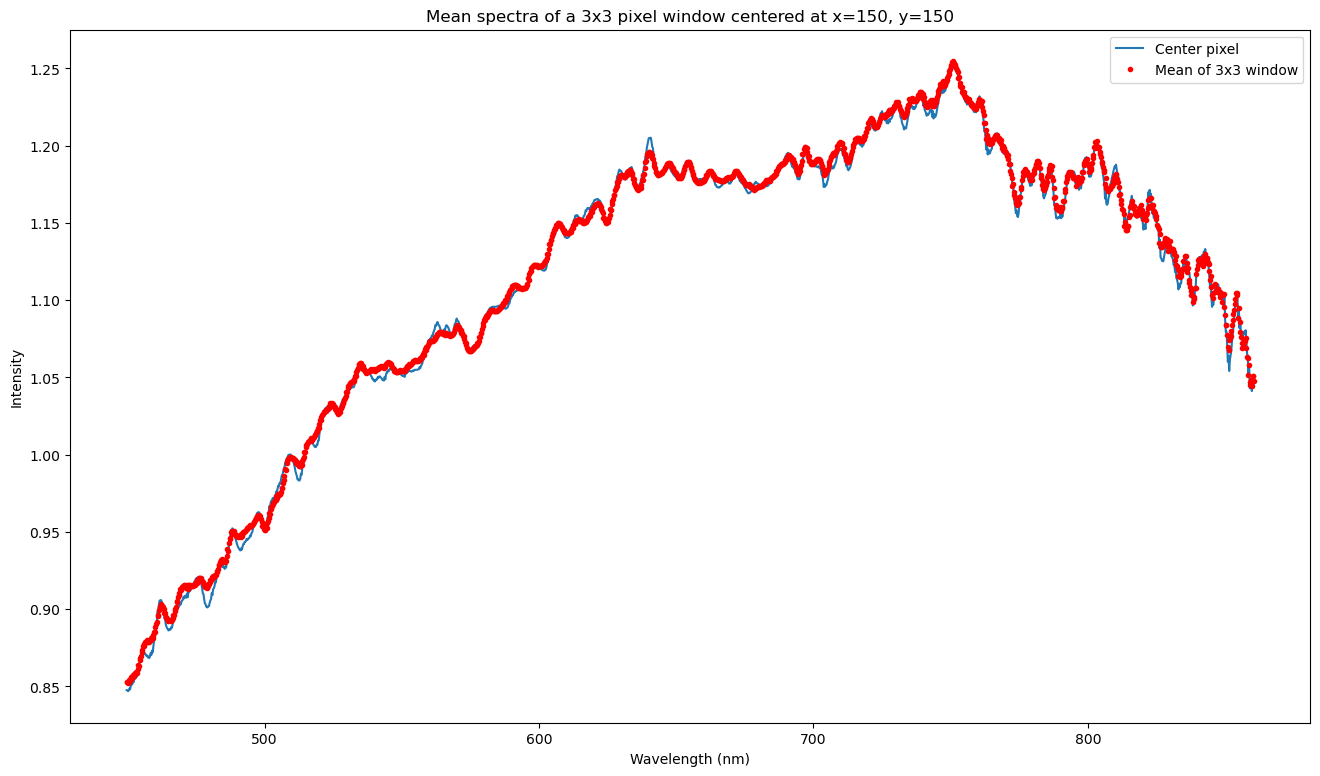

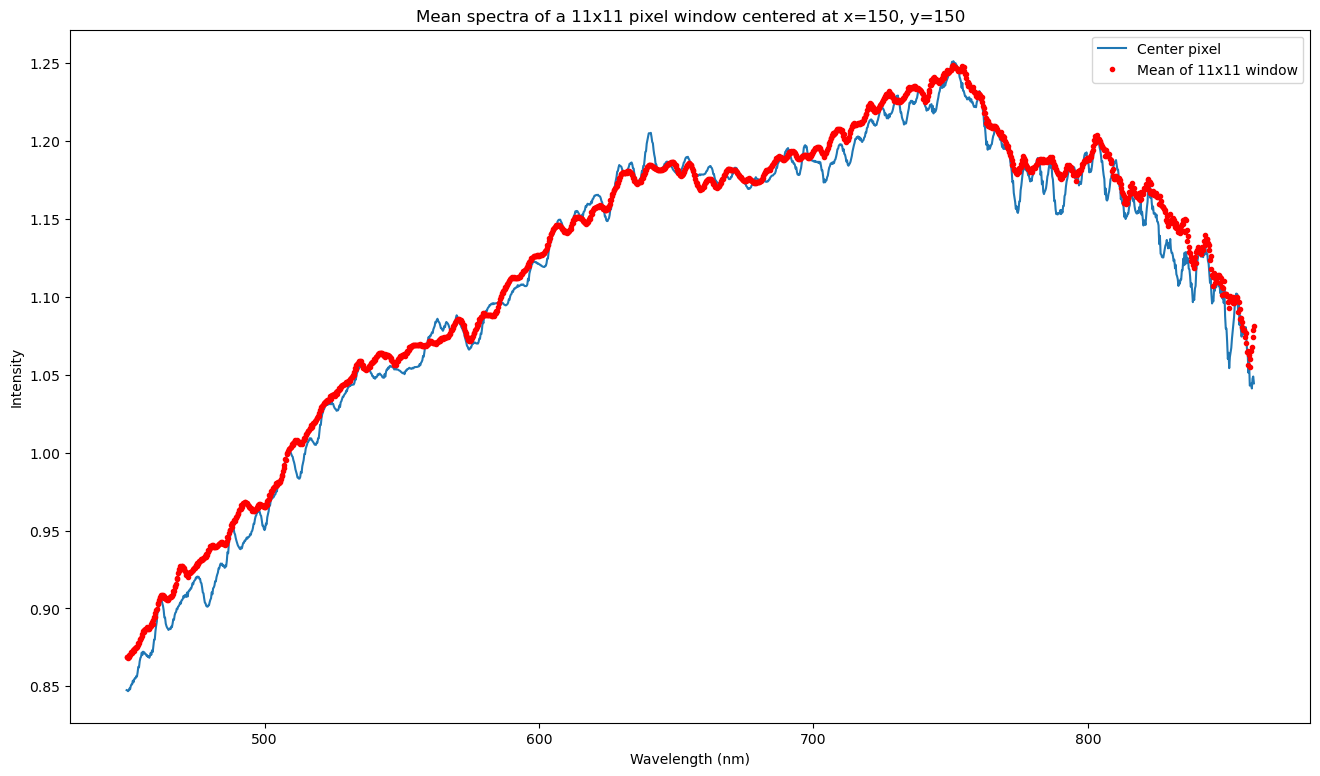

In [7]:
final_cube, final_wave = calibration_of_cube('HEM1', 'SPEC1', step=0.25)

print(final_cube.shape)
print(min(final_wave), max(final_wave))

plot_cube_slice_mean(final_cube, final_wave, 600)

plot_cube_spectra(final_cube, final_wave, 150, 150)
plot_cube_spectra_mean_3x3(final_cube, final_wave, 150, 150)
plot_cube_spectra_mean_11x11(final_cube, final_wave, 150, 150)

